<a href="https://colab.research.google.com/github/karlmaji/pytorch_learning/blob/master/ShuffleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 下载需要的库

In [1]:
!pip install einops

# 导入包 设置随机种子

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,random_split
import os
import numpy as np
import pandas as pd
from einops import rearrange,reduce,repeat
from einops.layers.torch import EinMix as Mix
from einops.layers.torch import Rearrange,Reduce
import random

def set_seed(seed):
  np.random.seed(seed)
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():  # GPU operation have separate seed
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(42)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


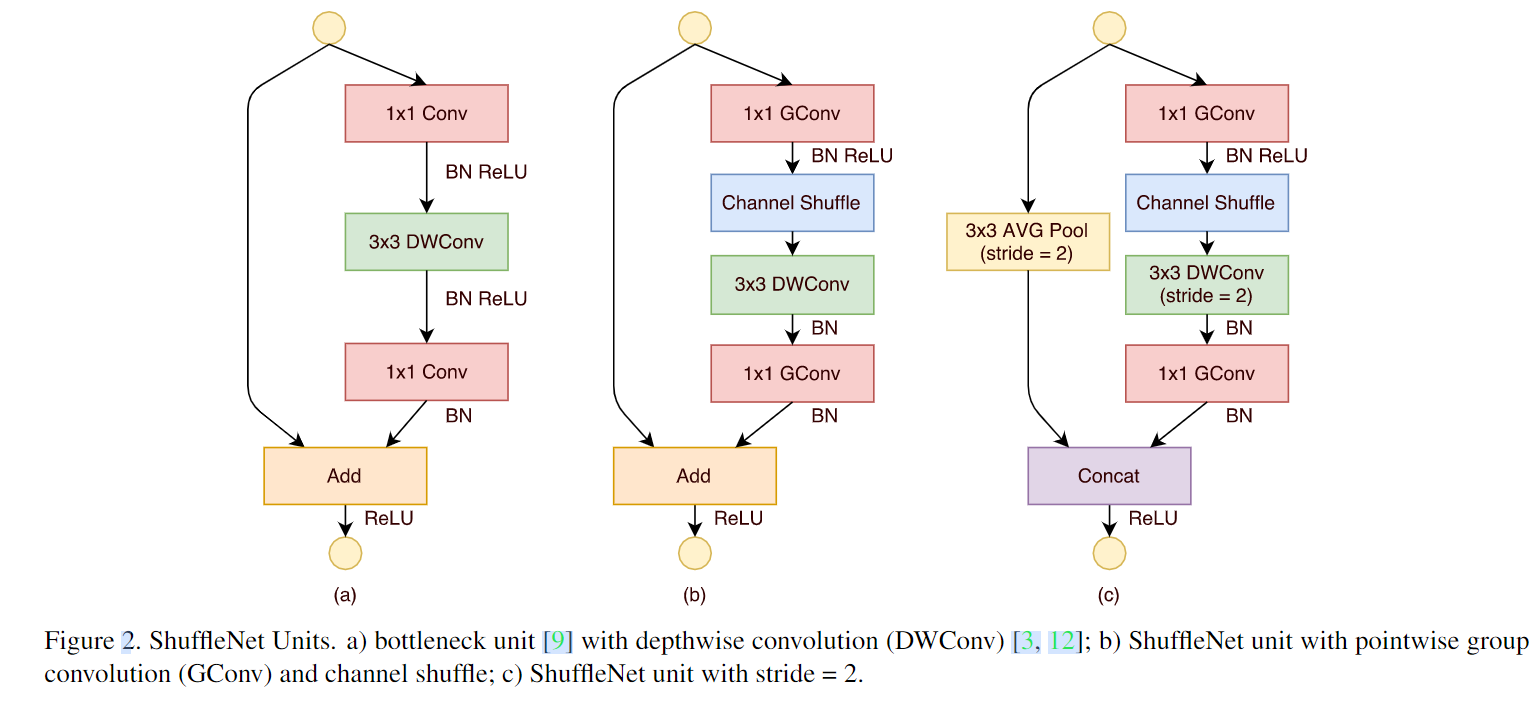

In [118]:
class ShuffleNet_Unit(nn.Module):
  def __init__(self,input_channel,output_channel,groups,group_conv = True,combine_type = 'add'):
    super(ShuffleNet_Unit,self).__init__()
    first_Gconv = groups if group_conv else 1
    # 论文中3.3.Network Architecture中论述了bottleneck_channels 是output_channels 的四分之一
    bottleneck_channel = output_channel // 4
    self.combine_type = combine_type
    if self.combine_type == 'add':
      #左侧旁路 对应b图连接方式
      self.left = Rearrange('...->...')
      depthwise_stride = 1
    else:
      #左侧旁路 对应C图连接方式
      self.left = nn.AvgPool2d(kernel_size = 3,stride = 2 ,padding = 1)
      depthwise_stride = 2
      output_channel -=input_channel
      assert output_channel > 0
    #右侧旁路
    self.right = nn.Sequential(
        #pointwise-Conv
        nn.Conv2d(input_channel,bottleneck_channel,(1,1),groups= first_Gconv,bias=False),
        nn.BatchNorm2d(bottleneck_channel),
        nn.ReLU(inplace=True),
        #shuffle channel
        Rearrange('b (c1 c2) h w -> b (c2 c1) h w',c1= groups),
        #depthwise-Conv
        nn.Conv2d(bottleneck_channel,bottleneck_channel,(3,3),\
                  stride=depthwise_stride,\
                  padding = 1,\
                  groups= bottleneck_channel,\
                  bias=False),
        nn.BatchNorm2d(bottleneck_channel),
        #pointwise-Conv
        nn.Conv2d(bottleneck_channel,output_channel,(1,1),groups= groups,bias=False),
        nn.BatchNorm2d(output_channel)
    )
  def forward(self,x):
    if self.combine_type == 'add':
     x = self.left(x) + self.right(x)
    else:
     x = torch.cat([self.left(x),self.right(x)],dim =1)
    return F.relu(x,inplace =True)


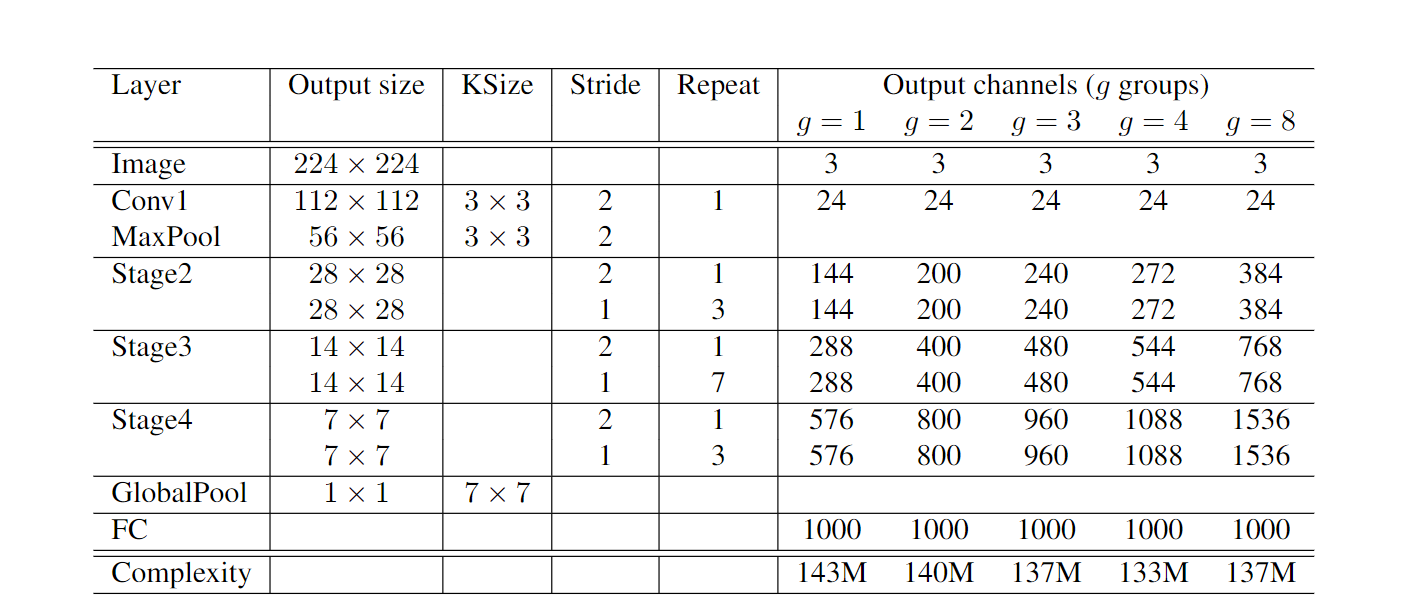

In [119]:
groups_output_channel_dic = {1:[24,144,288,576],2:[24,200,400,800],\
               3:[24,240,480,960],4:[24,272,544,1088],\
               8:[24,384,768,1536]}
class ShuffleNet1x(nn.Module):
  def __init__(self,input_channel,num_class,groups,output_channel):
    super(ShuffleNet1x,self).__init__()
    self.Conv1_MaxPool = nn.Sequential(
        nn.Conv2d(input_channel,output_channel[0],(3,3),stride=2,padding=1,bias=False),
        nn.BatchNorm2d(output_channel[0]),
        nn.ReLU(inplace=True),
        nn.MaxPool2d((3,3),stride=2,padding=1)
    )
    self.Stage2 = nn.Sequential(
        ShuffleNet_Unit(output_channel[0],output_channel[1],groups=groups,group_conv=False,combine_type='concat'),
        *[ShuffleNet_Unit(output_channel[1],output_channel[1],groups=groups,combine_type='add') for i in range(3)]
    )
    self.Stage3 = nn.Sequential(
        ShuffleNet_Unit(output_channel[1],output_channel[2],groups=groups,combine_type='concat'),
        *[ShuffleNet_Unit(output_channel[2],output_channel[2],groups=groups,combine_type='add') for i in range(7)]
    )
    self.Stage4 = nn.Sequential(
        ShuffleNet_Unit(output_channel[2],output_channel[3],groups=groups,combine_type='concat'),
        *[ShuffleNet_Unit(output_channel[3],output_channel[3],groups=groups,combine_type='add') for i in range(3)]
    )
    self.GlobalPool = Reduce('b c h w -> b c','mean')
    self.FC = nn.Linear(output_channel[3],num_class)
  def forward(self,x):
    x = self.Conv1_MaxPool(x)
    x = self.Stage2(x)
    x = self.Stage3(x)
    x = self.Stage4(x)
    x = self.GlobalPool(x)
    x = self.FC(x)
    return x

In [122]:
model = ShuffleNet1x(3,1000,8,groups_output_channel_dic[8])

In [123]:
total_param=0
for name,param in model.named_parameters():
  total_param += np.prod(param.size())
print(total_param)

2434768


In [88]:
x=torch.randn(3,3,224,224)
model(x).shape

torch.Size([3, 1000])